# ROMY - Barometer

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from src.baroseis import baroseis

In [2]:
# load config
# config = baroseis.load_from_yaml("./data/config_FFBI_DROMY_20240315_file.yaml")
config = baroseis.load_from_yaml("./data/config_FFBI_FUR_20240324_file.yaml")


In [3]:
# Initialize baroseis object
bs = baroseis(conf=config)

# Load data specified in config
bs.load_data()

Creating new Hilbert transform data...
 -> No resampling required!

>Runtime: 0.0 minutes



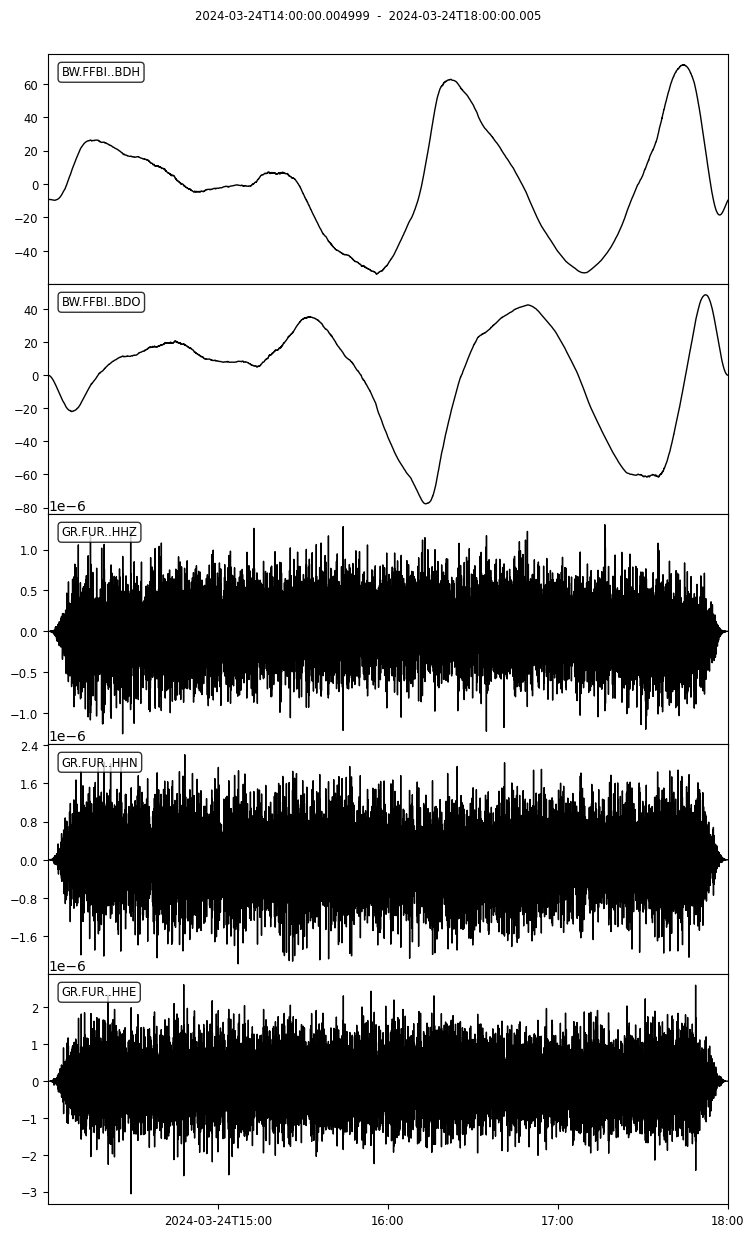

In [4]:
bs.st.plot(equal_scale=False);

Removing mean and trend...
Applying bandpass filter: 0.0005-0.03 Hz


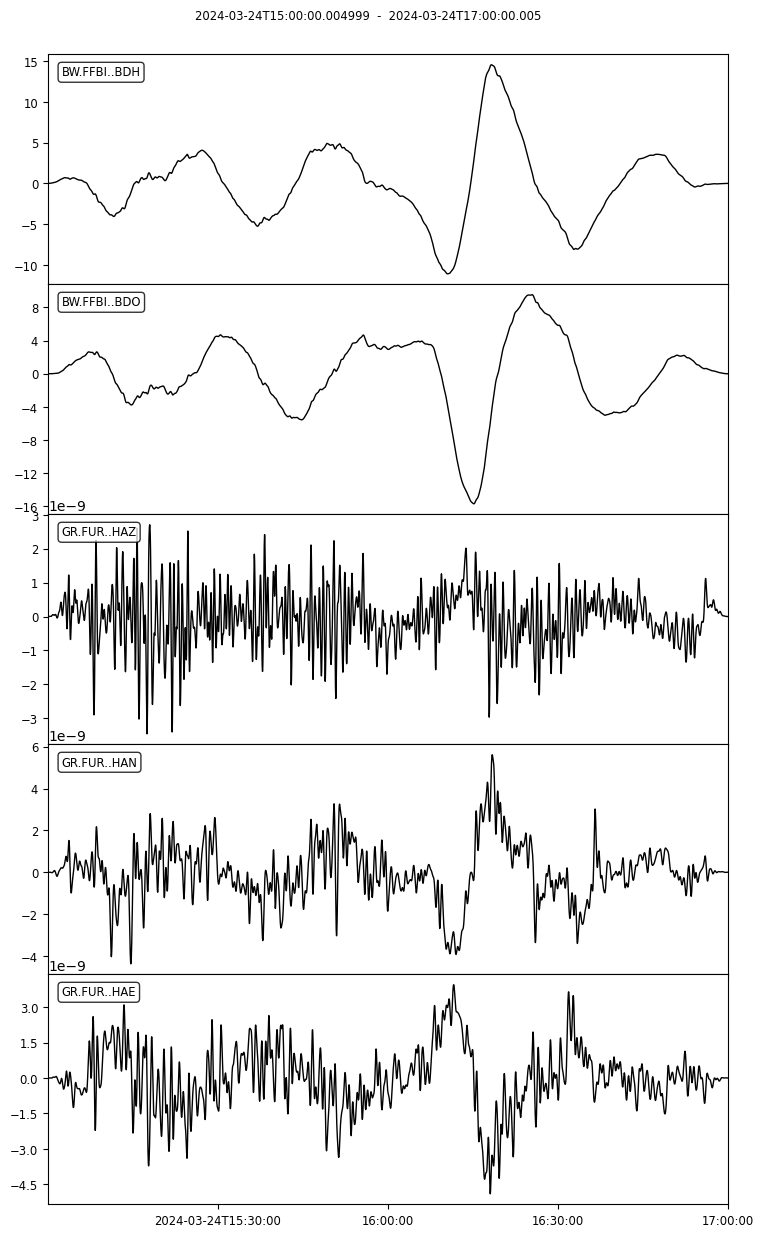

In [5]:
# band pass filer
bs.filter_data(fmin=0.0005, fmax=0.03)

# detrend
bs.st.detrend("demean")

# taper edges
bs.st.taper(0.1)

# integrate rotation to tilt
# bs.integrate_data(method="cumtrapz") # method = "cumtrapz" or "spline"

# convert acceleration to tilt
for tr in bs.st:
    if tr.stats.channel[1] == "H":
        tr.stats.channel = tr.stats.channel[0] + "A" + tr.stats.channel[-1]
        if tr.stats.channel[-1] in ["N", "E"]:
            tr.data = -tr.data/9.81

# # trim waveforms
bs.st = bs.st.trim(bs.config['tbeg'], bs.config['tend'])

# detrend waveforms
bs.st.detrend("demean")

# taper edges
bs.st.taper(0.05)

# show new waveforms
bs.st.plot(equal_scale=False);


### Compuate and Compare Coherency

In [6]:
Twin = (bs.st[0].stats.npts / bs.st[0].stats.sampling_rate) // 2
overlap = 0.5
smooth_points = 31


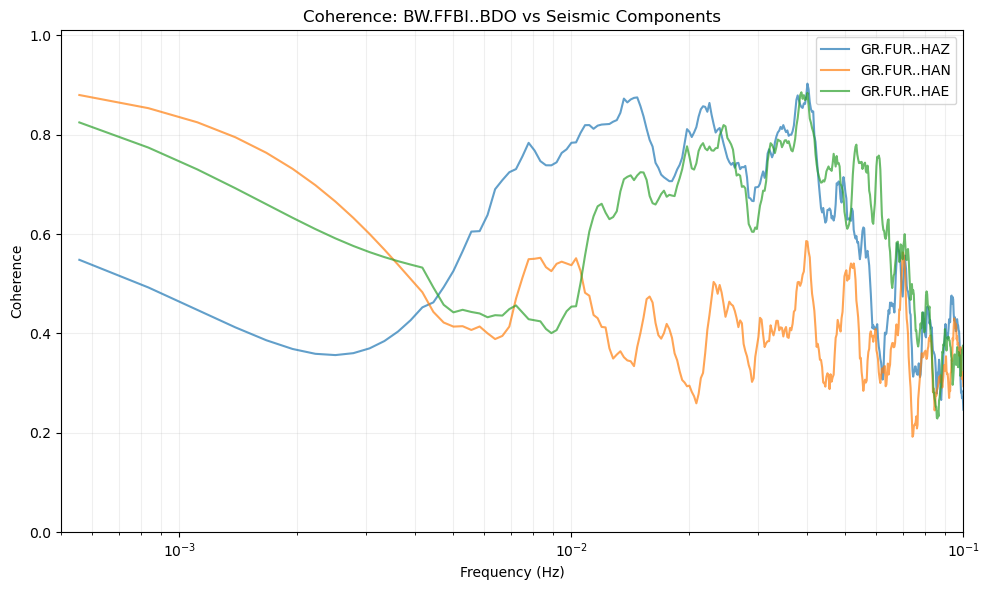

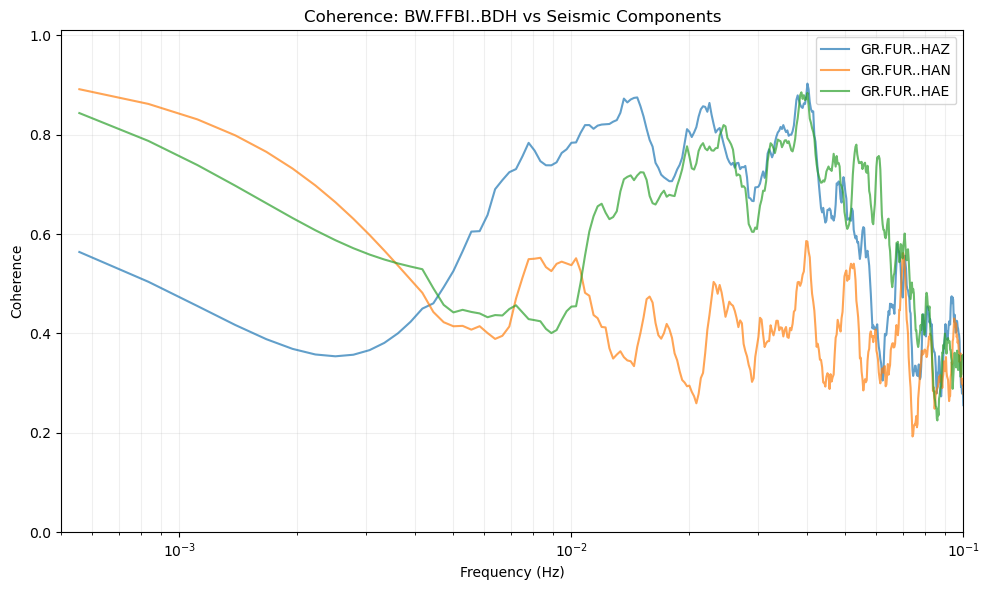

In [7]:
# compute coherence
coherence = bs.compute_coherence(
    window_sec=Twin,  # 1 hour windows
    overlap=overlap,      # 50% overlap
    smooth_points=smooth_points, # Smoothing window
    baro_channel="BDO",
    channels=["HAZ", "HAN", "HAE"]
)

# plot results
fig = bs.plot_coherence(
    coherence,
    fmin=0.0005,
    fmax=0.1,
    out=True,
)

# fig.savefig(f"./figures/event_{bs.config['tbeg']}_{bs.config['tend']}_bdo_coherence.png")

# compute coherence
coherence = bs.compute_coherence(
    window_sec=Twin,  # 1 hour windows
    overlap=overlap,      # 50% overlap
    smooth_points=smooth_points, # Smoothing window
    baro_channel="BDH",
    channels=["HAZ", "HAN", "HAE"]

)

# plot results
fig = bs.plot_coherence(
    coherence,
    fmin=0.0005,
    fmax=0.1,
    out=True,
)

# fig.savefig(f"./figures/event_{bs.config['tbeg']}_{bs.config['tend']}_bdh_coherence.png")


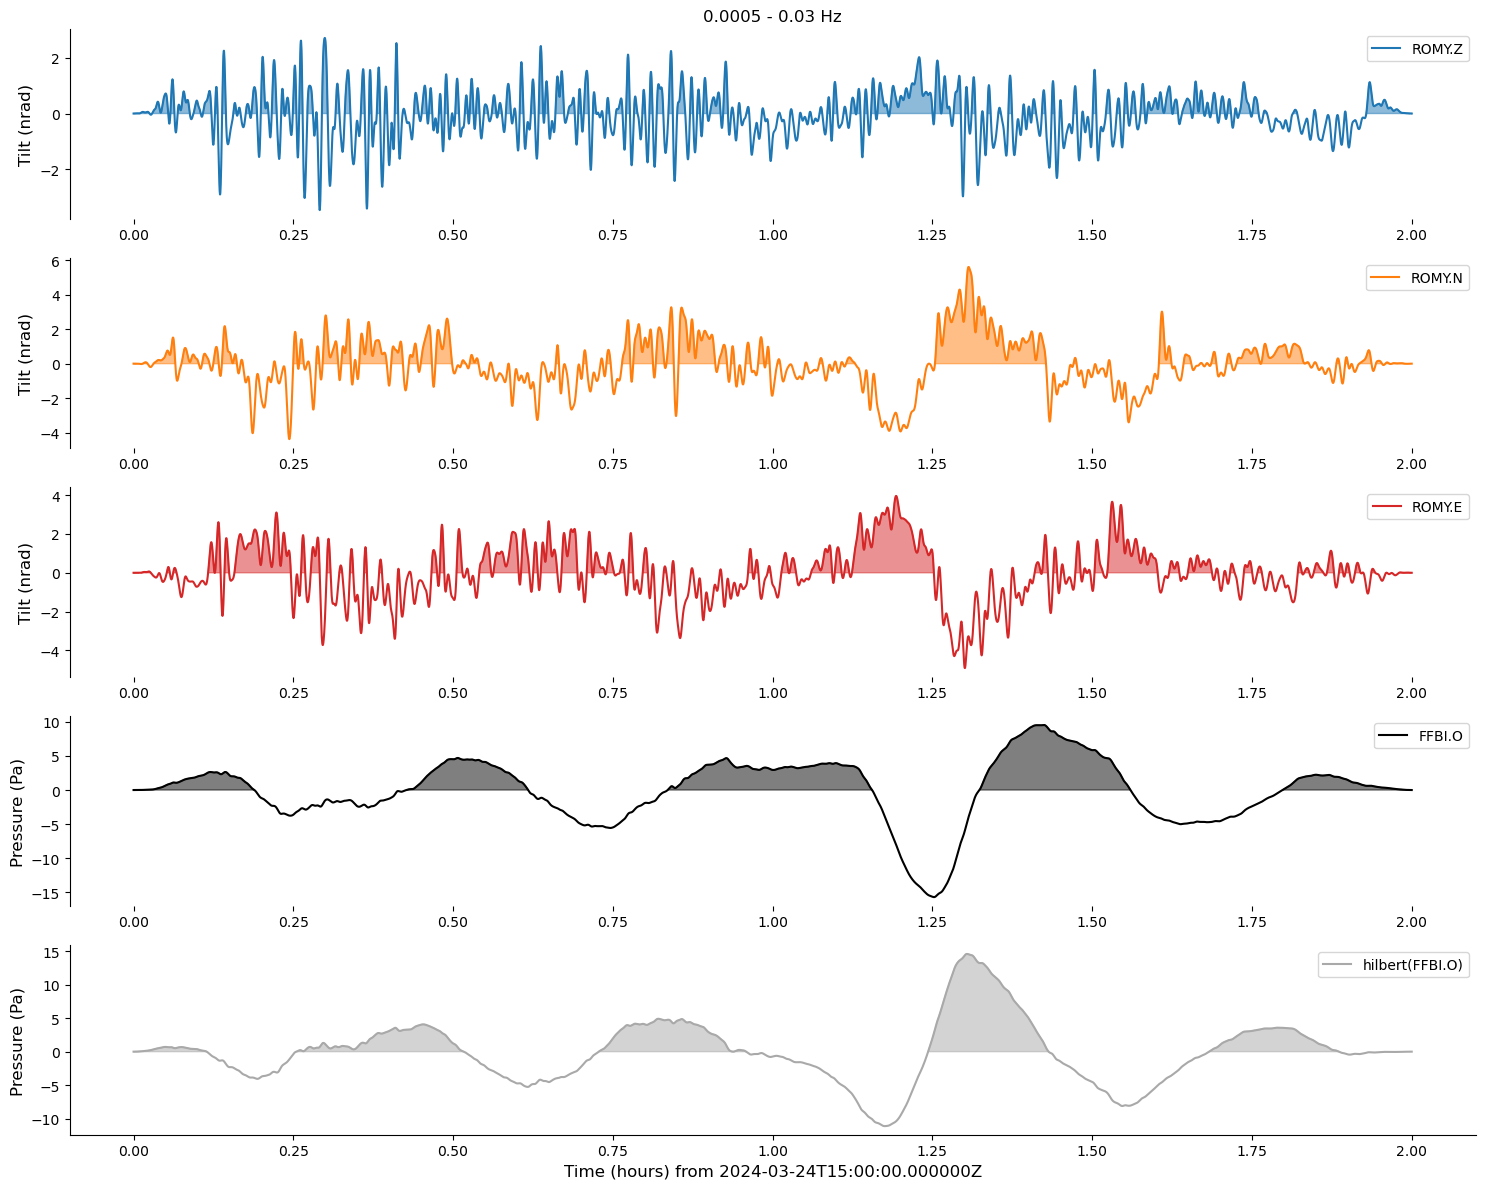

In [8]:
fig = bs.plot_waveforms(bs.st, time_unit="hours", channel_type="A")

# fig.savefig(f"./figures/event_{bs.config['tbeg']}_{bs.config['tend']}_waveforms.png")


Component N:
P coefficient: 2.102 nrad/hPa
H coefficient: 22.645 nrad/hPa
Variance reduction: 56.9%

Component E:
P coefficient: -1.871 nrad/hPa
H coefficient: -21.115 nrad/hPa
Variance reduction: 53.8%

Component Z:
P coefficient: -4.232 nrad/hPa
H coefficient: -1.979 nrad/hPa
Variance reduction: 7.2%


/home/andbro/cursorfiles/baroseis/src/baroseis.py:2342: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


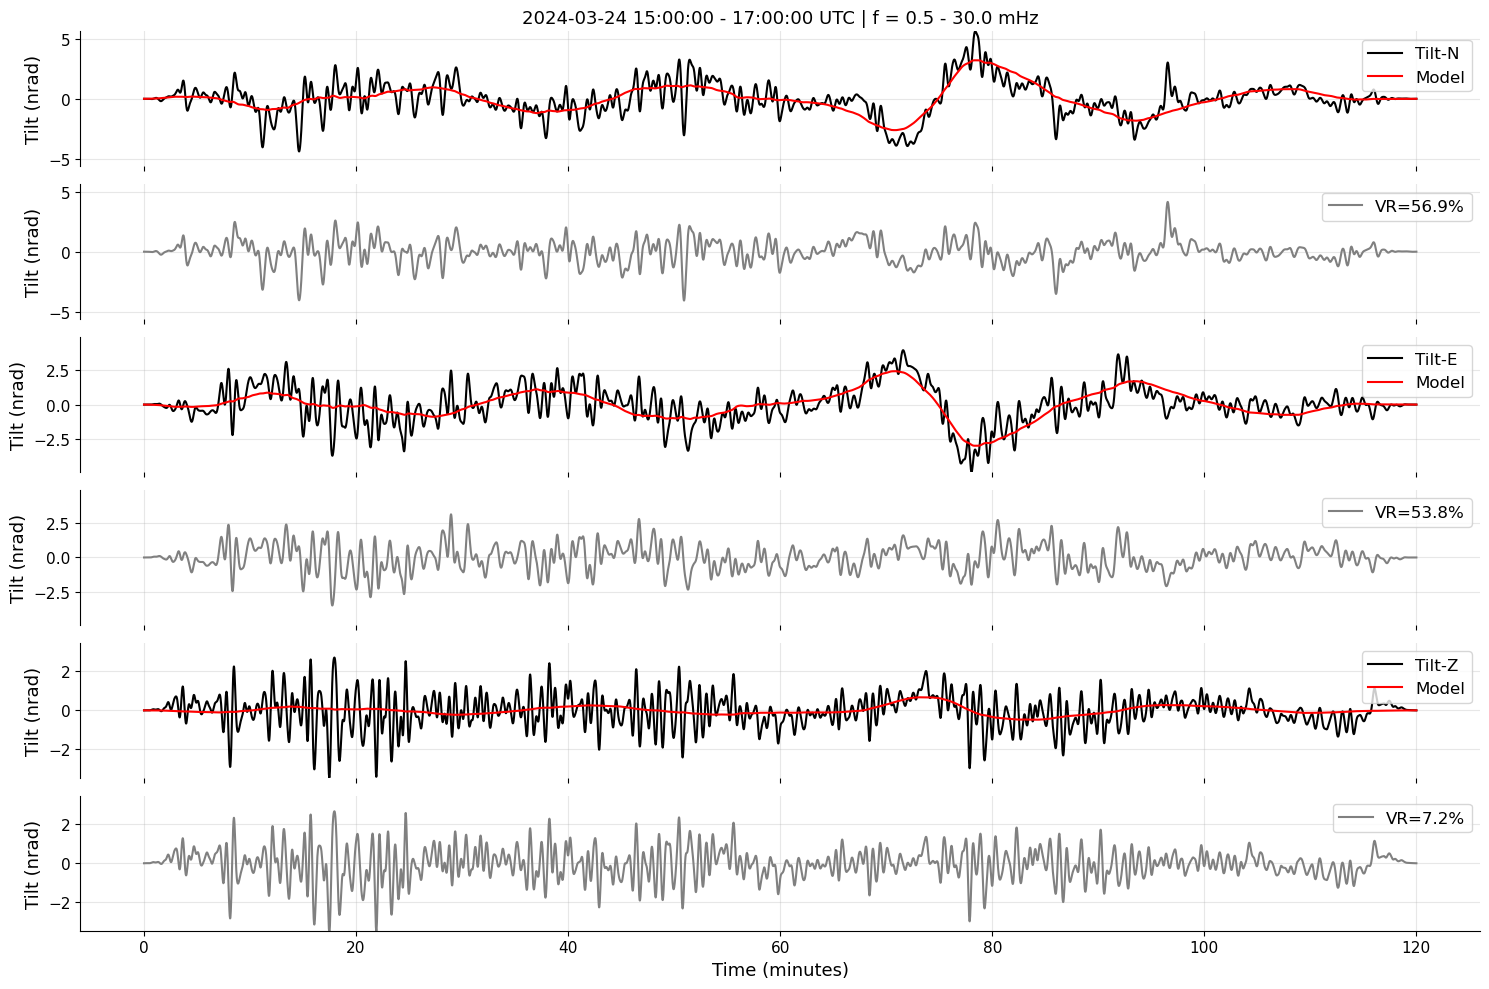

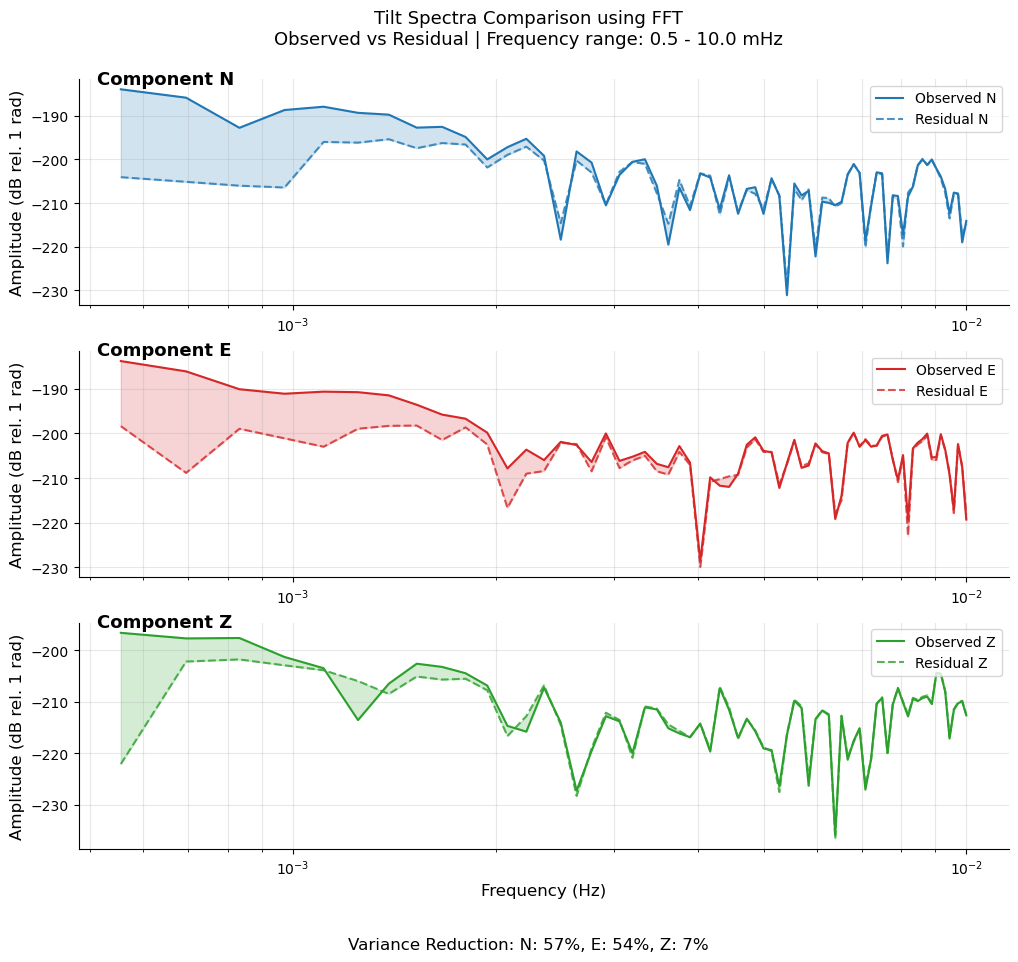

In [9]:
bs.predict_tilt_from_pressure(
    method="least_squares",
    channel_type="A",
    zero_intercept=True
)

fig = bs.plot_residuals(
    time_unit="minutes",
    channel_type="A",
    out=True
)

# fig.savefig(f"./figures/event_{bs.config['tbeg']}_{bs.config['tend']}_H_residual_waveforms.png")

fig = bs.compare_spectra(
    method='fft',
    channel_type='A',
    fmin=0.0005,
    fmax=0.01,
    db_scale=True,
)

# fig.savefig(f"./figures/event_{bs.config['tbeg']}_{bs.config['tend']}_H_residual_spectra.png")


### With Pressure Derivative

Now take the barometric derivatives and use them for modeling the rotation rate


Component N (with derivatives):
P coefficient: -8.422 nrad/hPa
H coefficient: 10.328 nrad/hPa
DP coefficient: 2721.088 nrad/hPa/s
DH coefficient: -2333.095 nrad/hPa/s
Variance reduction: 65.5%

Component E (with derivatives):
P coefficient: -15.276 nrad/hPa
H coefficient: -3.074 nrad/hPa
DP coefficient: -3980.627 nrad/hPa/s
DH coefficient: -2965.760 nrad/hPa/s
Variance reduction: 71.8%

Component Z (with derivatives):
P coefficient: -15.089 nrad/hPa
H coefficient: -15.039 nrad/hPa
DP coefficient: 2885.257 nrad/hPa/s
DH coefficient: -2407.266 nrad/hPa/s
Variance reduction: 35.3%


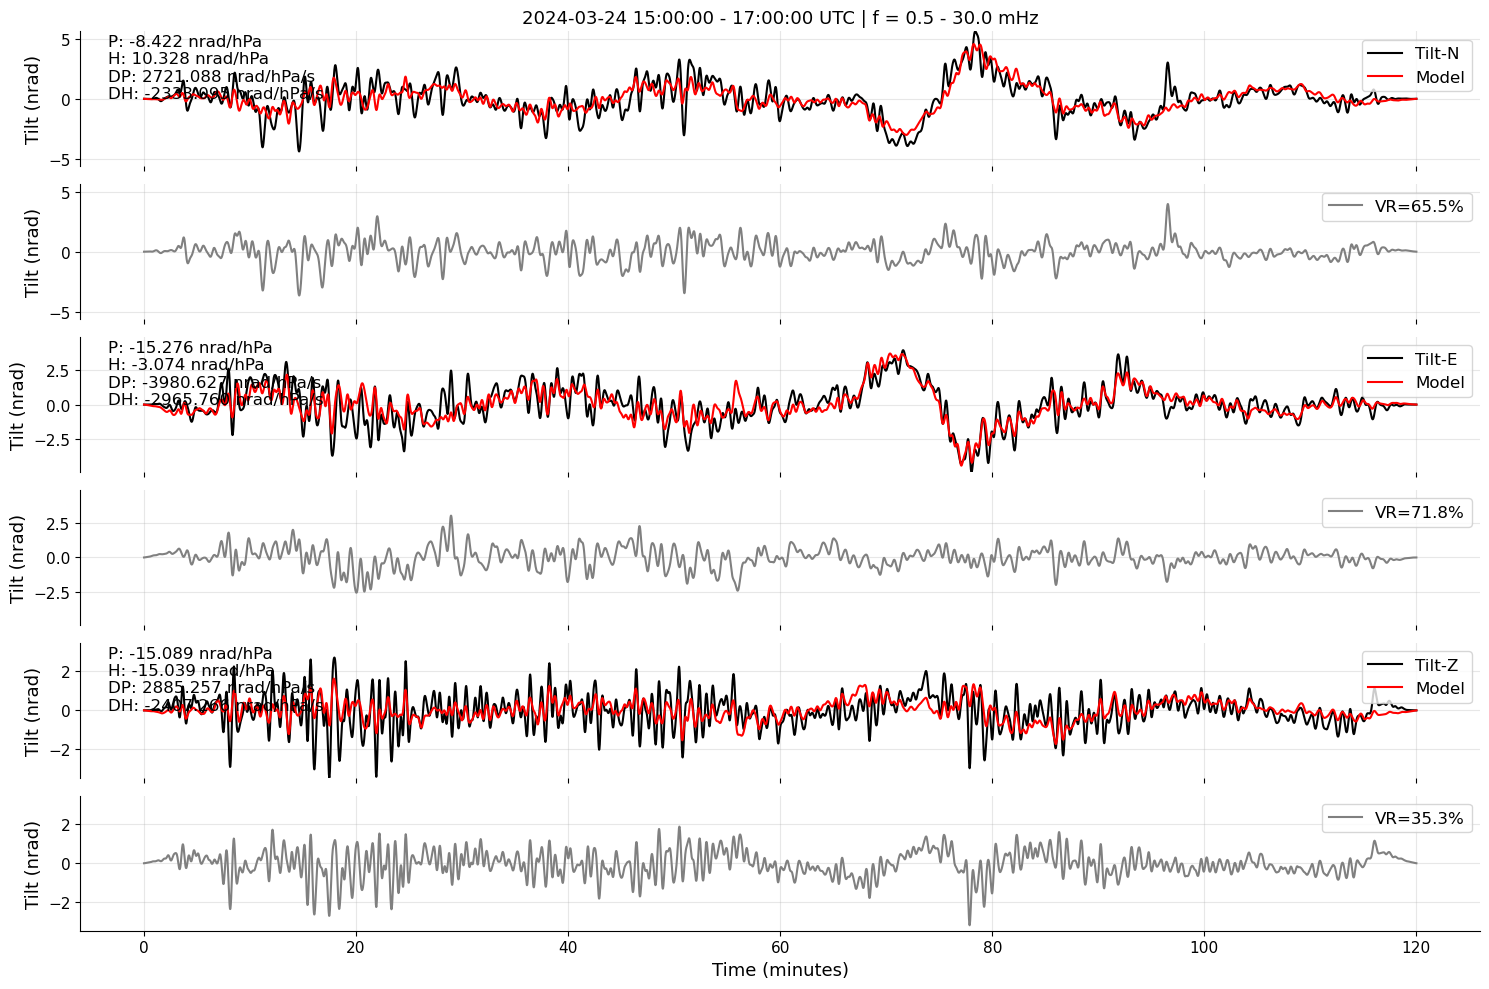

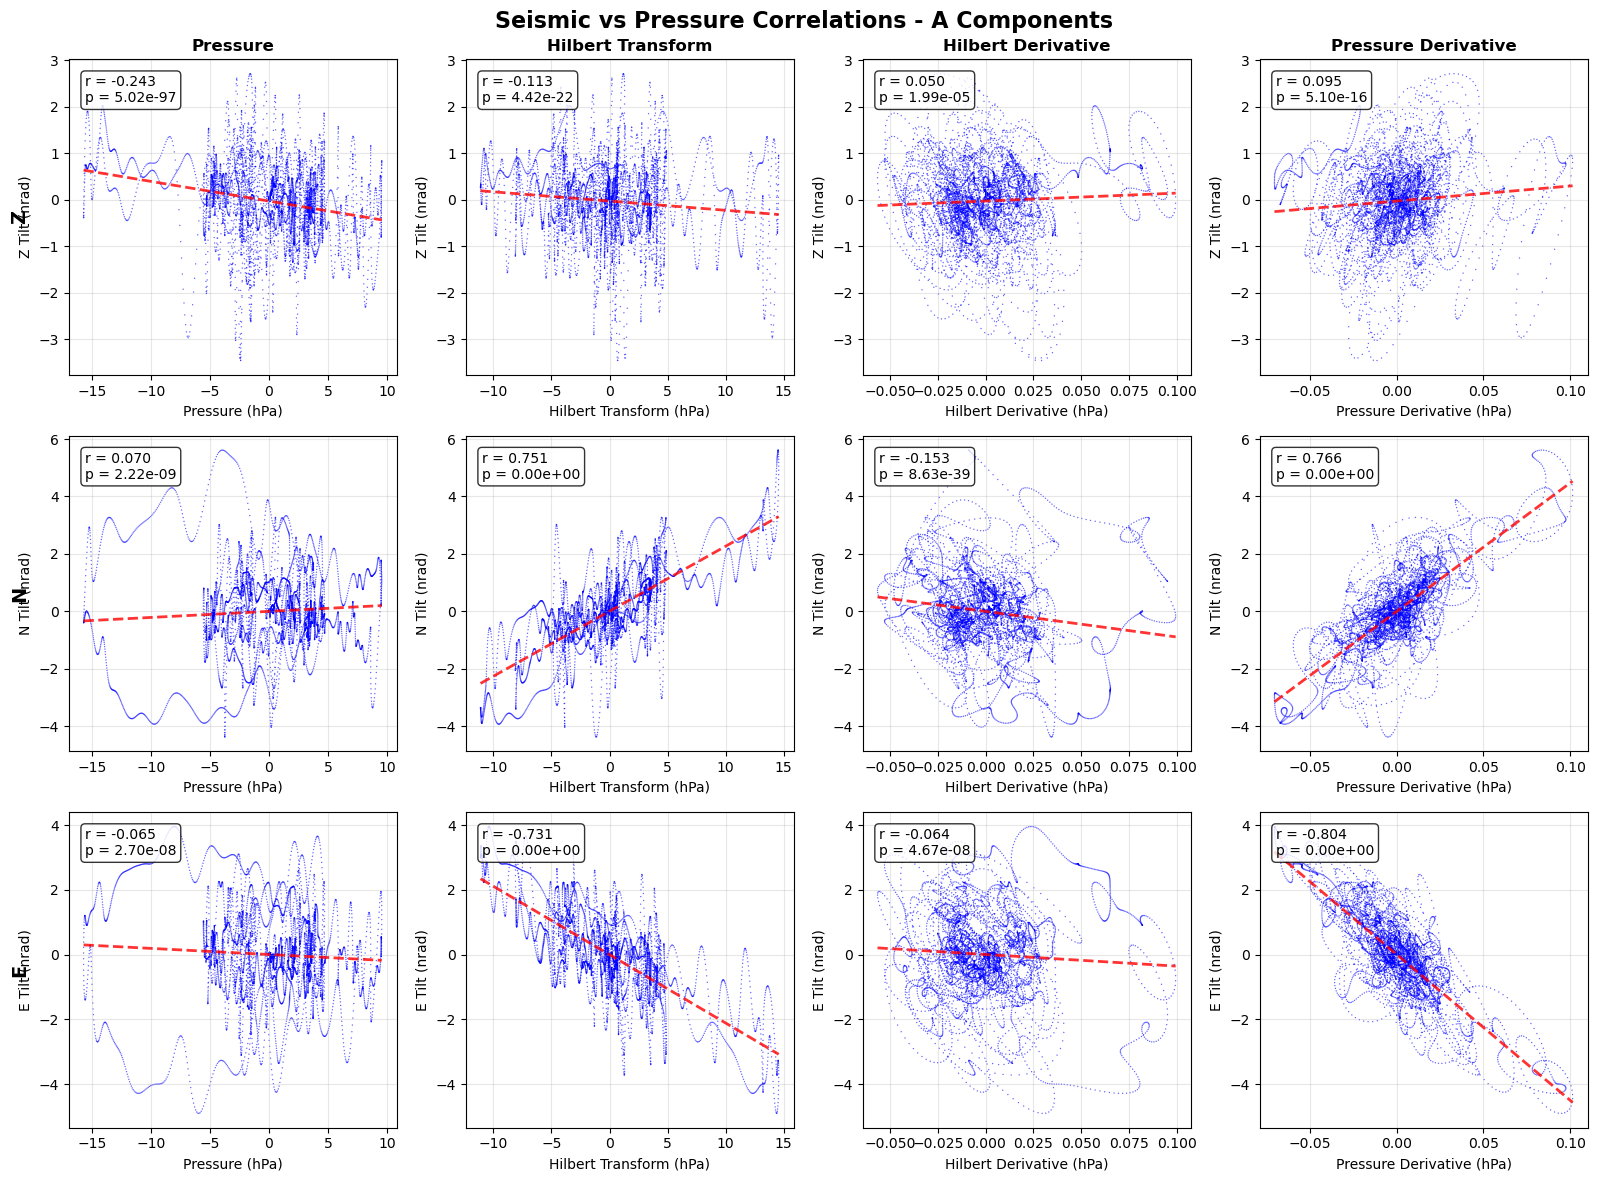

In [10]:
cha = "A"

bs.model_tilt_from_pressure(
    method="least_squares",
    channel_type=cha,  # for rotation rate
    zero_intercept=True,
    verbose=True
)

fig = bs.plot_residuals_derivatives(
    channel_type=cha,
    out=True
)

fig = bs.plot_scatter_correlations(channel_type=cha, out=True)
